# Spike Triggered Averages
Notebook that plots spiked triggered averages for most confident synapses (perturbed data). 
Updated 7/24/17

## Preprocessing and Setup

In [1]:
### Import modules
import os
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

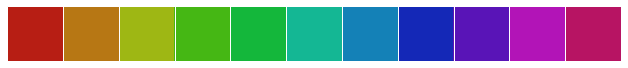

In [2]:
### Set color palette
import seaborn as sns
cp = sns.hls_palette(11, l=.4, s=.8)
sns.palplot(cp)
import matplotlib.gridspec as gridspec

In [3]:
### Set directory
os.chdir('/groups/turaga/home/kuperwajsi/bay_inf')

In [4]:
### Restore trained model and parameters
from model_old_pert import *
saver_pert.restore(session, "./photo_full_upsampled/model_photo_full")

INFO:tensorflow:Restoring parameters from ./photo_full_upsampled/model_photo_full


In [5]:
### Function to do upsampling by averaging two nearest bins
def upsampling_average(factor, data, columns, rows):
    data_upsampled = np.zeros((columns * factor, rows))
    for i in range(rows):
        counter = 0
        for y in range(columns-1):
            data_upsampled[counter,i] = data[y,i]
            data_upsampled[counter + 1,i] = (data[y,i] + data[y + 1,i]) / 2
            counter += 2
    return data_upsampled

### Function to do upsampling by setting to 0
def upsampling_zero(factor, data, columns, rows):
    data_upsampled = np.zeros((columns * factor, rows))
    for i in range(rows):
        counter = 0
        for y in range(columns-1):
            data_upsampled[counter,i] = data[y,i]
            data_upsampled[counter + 1,i] = 0
            counter += 2
    return data_upsampled

In [6]:
### Load clean data
clean_data = 'l161_clean.h5'
file = h5py.File(clean_data, 'r')

### Extract perturbations and fluorescent traces
traces_spont = file["spont/traces"].value/100
traces_photo = file["photo/traces"].value/100
traces_spont = (traces_spont - np.mean(traces_spont) + np.mean(traces_photo))*\
                   np.sqrt(np.var(traces_photo)/np.var(traces_spont))

### Specify for perturbed data
stim_frames = file["%(data)s/frames" % dm].value
stim_cells  = file["%(data)s/types" % dm].value - 1

### Set other useful variables
T_total = traces_photo.shape[0]
Nc = traces_photo.shape[1]
Ns = np.max(stim_cells) + 1
stim = np.zeros([T_total, Ns])
stim_frames = np.ones([5, 1], dtype=np.int32) * np.transpose(stim_frames)
stim[(stim_frames, stim_cells)] = 1

upsample_factor = 2
T = 18000
Nb = 2
Nl = 2

file.close()

## Look at Stim Triggered Averages for Good Neurons

In [14]:
### Function to calculate and plot spike-triggered averages for entire trial for multi neurons together
def spike_trigger_avg_multi(input_neuron, upsample, cp, bin_period, fs=14,
                      fig=None, grid=None):
    
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax3 = fig.add_subplot(gs[1])
    
    length = int(2*(1/bin_period))
    
    color_count = 0
    
    for neuron in input_neuron:
        for half in range(4):
            start_run = half*T

            ### Set correct dimensions for fluorescence and perturbations
            traces_half = traces_photo[start_run:start_run+T, :]
            stim_half = stim[start_run:start_run+T, :]

            traces_ups_half = upsampling_average(upsample_factor, traces_half, T, Nc)
            perturbations_ups_half = upsampling_zero(upsample_factor, stim_half, T, Ns)

            ### Recover the inferred spikes
            inferred_spikes = session.run(spikes.Q.mean(), feed_dict = {ca_raw_upsampled: traces_ups_half, raw_inp_upsampled: perturbations_ups_half})

            ### Recover the reconstructed fluorescent traces
            reconstruction = session.run(calcium.Erecon, feed_dict = {ca_raw_upsampled: traces_ups_half, raw_inp_upsampled: perturbations_ups_half})

            curr_traces = traces_ups_half[:, neuron]
            curr_recon = reconstruction[:, neuron]
            curr_spikes = inferred_spikes[:, neuron]
            curr_stim = perturbations_ups_half[:, neuron]
            #curr_stim = stim

            average_trace = np.zeros(int(length*2))
            average_recon = np.zeros(int(length*2))
            average_spikes = np.zeros(int(length*2))
            counter = 0
            num_perts = 0

            x = np.arange(len(average_trace))
            t = x * bin_period

            for i in curr_stim:
                if i != 0:
                    average_trace += curr_traces[counter-length:counter+length:,]
                    average_recon += curr_recon[counter-length:counter+length:,]
                    average_spikes += curr_spikes[counter-length:counter+length:,]
                    num_perts += 1
                counter += 1

        average_trace = average_trace/num_perts
        average_recon = average_recon/num_perts
        average_spikes = average_spikes/num_perts

        ax1.set_ylabel("Activity", fontsize=fs + 2, y=0.5)
        ax1.plot(t, average_trace, label="Trace", color=cp[color_count])
        #ax1.plot(t, average_recon, label="Recon", color=cp[1])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        #ax1.set_xlim([t.min(), t.max()])
        #ax1.set_ylim([0, 0.13])
        #ax1.set_xlabel('Time in Seconds', fontsize=fs + 2)

        ax3.plot(t, average_spikes, label="Recon", color=cp[color_count])
        ax3.set_xlim([t.min(), t.max()])
        #ax3.set_ylim([0, 1])
        ax3.set_ylabel('Inferred', fontsize=fs + 2, y=0.5)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.set_xlabel('Time in Seconds', fontsize=fs + 2)
        
        color_count += 2

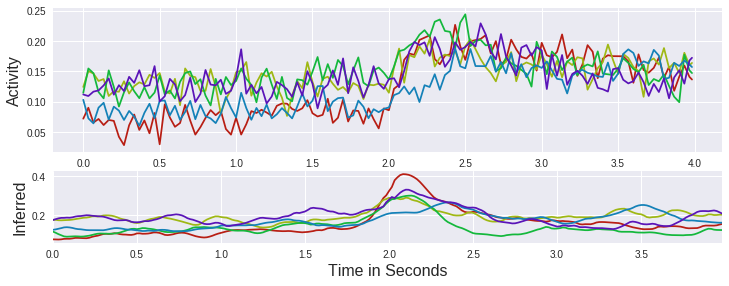

In [16]:
good_neurons = [0,4,6,14,17]

spike_trigger_avg_multi(good_neurons, 2, cp, 1/60)

## Visualize Confident Synapses

In [8]:
### Function to plot reconstructions together with the real traces
def plot_inf_soma_gt_recon(datatype, infered_spike, gt_spike, test_fluor,
                           recon_fluor, bin_period, upsample, cp, fs=14,
                           start_sample=0, fig=None, grid=None):
    #infered_spike = infered_spike.reshape((test_fluor.shape[0], upsample))
    #infered = np.sum(infered_spike, axis=1)
    infered=infered_spike
    if fig is None:
        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    else:
        gs = gridspec.GridSpecFromSubplotSpec(3, 1,
                                              subplot_spec=grid, height_ratios=[2, 1, 1])

    ax1 = fig.add_subplot(gs[0])
    ax3 = fig.add_subplot(gs[1])
#     ax4 = fig.add_subplot(gs[2])

    x = np.arange(len(test_fluor)) + start_sample
    t = x * bin_period
    # gs.tight_layout(fig, h_pad=-1.5)

    ax1.set_ylabel(datatype, fontsize=fs + 2, y=0.5)
    ax1.plot(t, test_fluor, label="Trace", color=cp[4])
    ax1.plot(t, recon_fluor, label="Recon", color=cp[1])
    ax1.get_xaxis().set_ticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim([t.min(), t.max()])

    ax3.vlines(t, np.zeros_like(infered), infered, color=cp[1])
    ax3.set_xlim([t.min(), t.max()])
    ax3.set_ylim([0, 1])
    ax3.set_ylabel('inferred', fontsize=fs + 2, y=0.5)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlabel('Time in Seconds', fontsize=fs + 2)

#     ax4.vlines(t, np.zeros_like(gt_spike), gt_spike, color=cp[0])
#     ax4.set_xlim([t.min(), t.max()])
#     ax4.set_ylim([0, upsample])
#     ax4.set_ylabel('gt', fontsize=fs + 2, y=0.5)
#     ax4.spines['top'].set_visible(False)
#     ax4.spines['right'].set_visible(False)
#     ax4.set_xlabel('Time in Seconds', fontsize=fs + 2)

    # ax1.tick_params(axis='both', labelsize=fs)
    # ax3.tick_params(axis='both', labelsize=fs)

In [9]:
### Function to plot reconstructions together with the real traces and perturbations
def plot_inf_soma_stim_recon(datatype, infered_spike, gt_spike, test_fluor,
                           recon_fluor, stim, bin_period, upsample, cp, fs=14,
                           start_sample=0, fig=None, grid=None):
    #infered_spike = infered_spike.reshape((test_fluor.shape[0], upsample))
    #infered = np.sum(infered_spike, axis=1)
    infered = infered_spike
    if fig is None:
        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    else:
        gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid, height_ratios=[2, 1, 1])

    ax1 = fig.add_subplot(gs[0])
    ax3 = fig.add_subplot(gs[1])
#     ax4 = fig.add_subplot(gs[2])

    x = np.arange(len(test_fluor)) + start_sample
    t = x * bin_period
    # gs.tight_layout(fig, h_pad=-1.5)

    ax1.set_ylabel(datatype, fontsize=fs + 2, y=0.5)
    ax1.plot(t, test_fluor, label="Trace", color=cp[4])
    ax1.plot(t, recon_fluor, label="Recon", color=cp[1])
    #ax1.plot(t, stim, label="Stimulation", color=cp[6])
    ax1.vlines(t, np.zeros_like(stim), stim, label="Stimulation", color=cp[6])
    ax1.get_xaxis().set_ticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim([t.min(), t.max()])
    ax1.set_ylim([-0.3, 0.8])

    ax3.vlines(t, np.zeros_like(infered), infered, color=cp[1])
    ax3.set_xlim([t.min(), t.max()])
    ax3.set_ylim([0, 1])
    ax3.set_ylabel('inferred', fontsize=fs + 2, y=0.5)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlabel('Time in Seconds', fontsize=fs + 2)

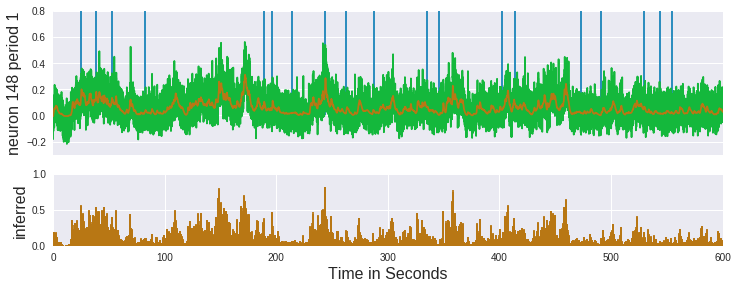

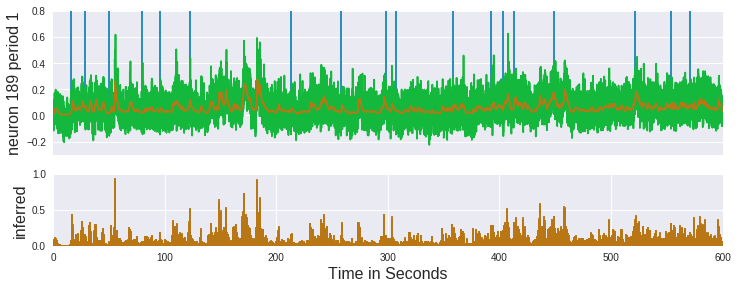

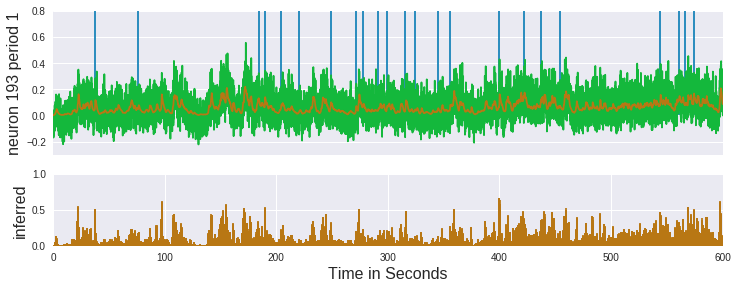

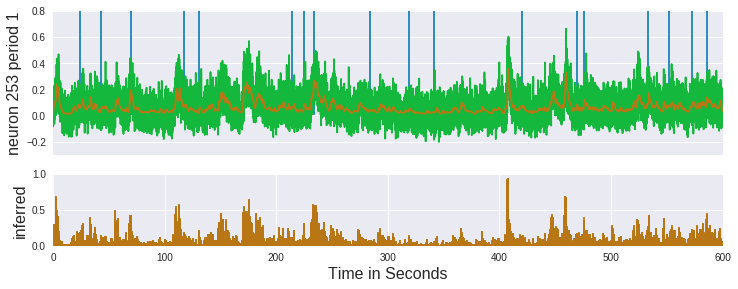

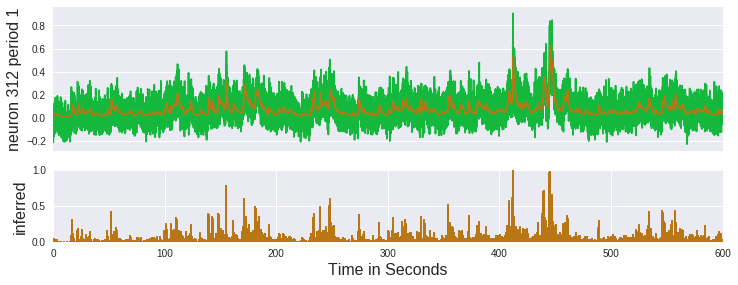

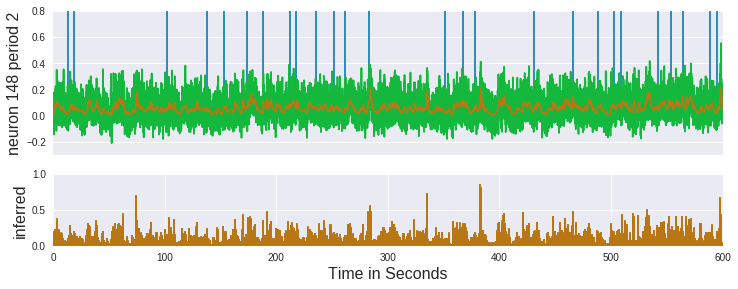

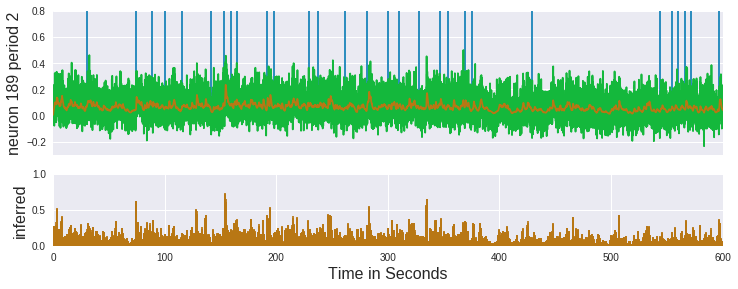

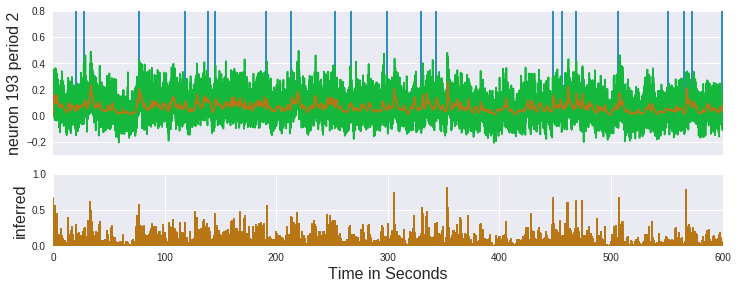

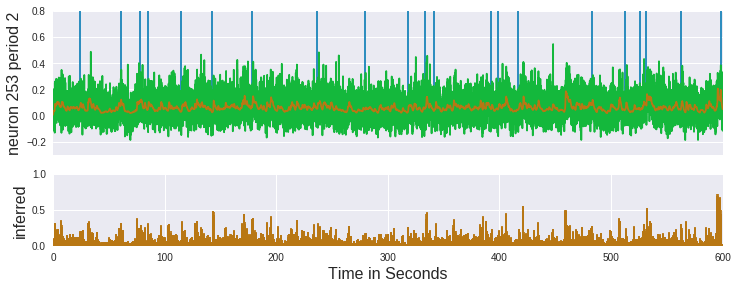

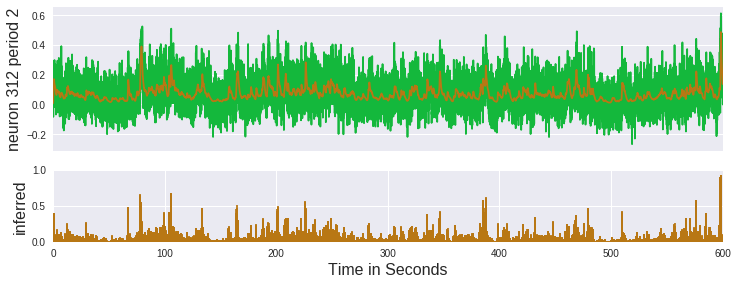

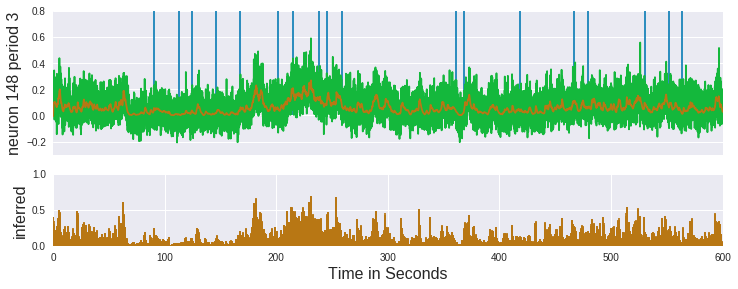

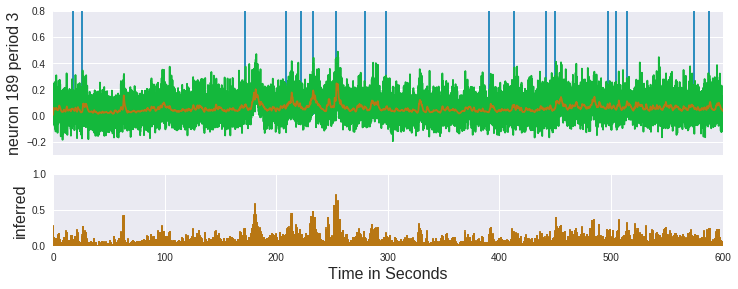

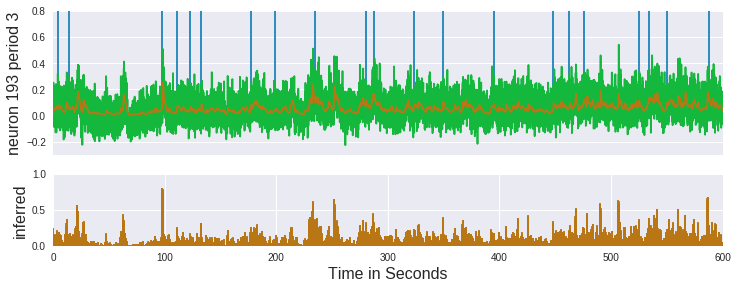

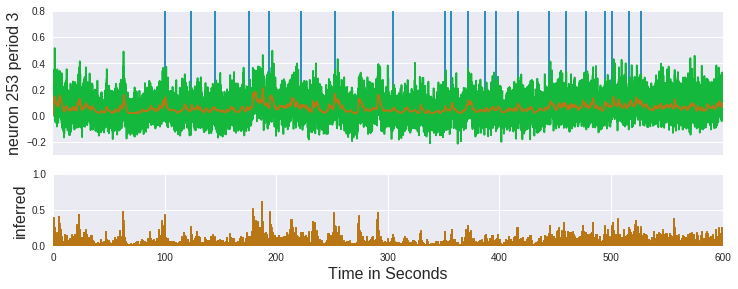

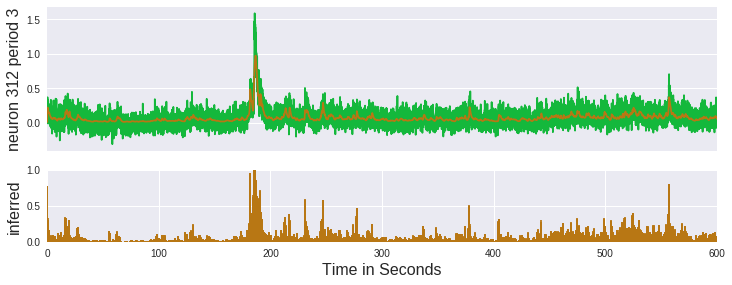

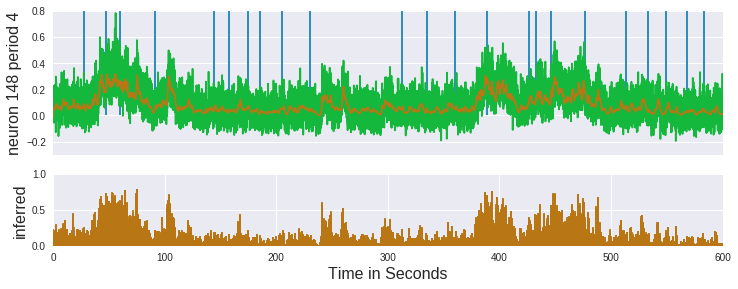

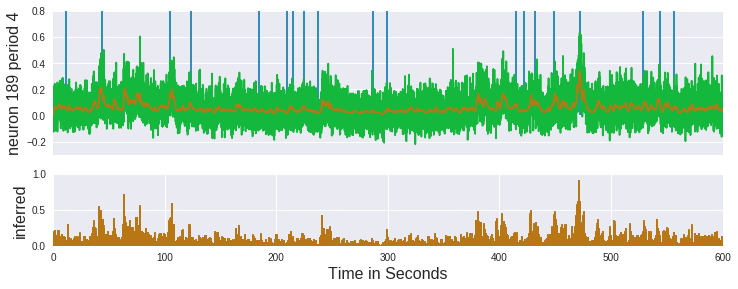

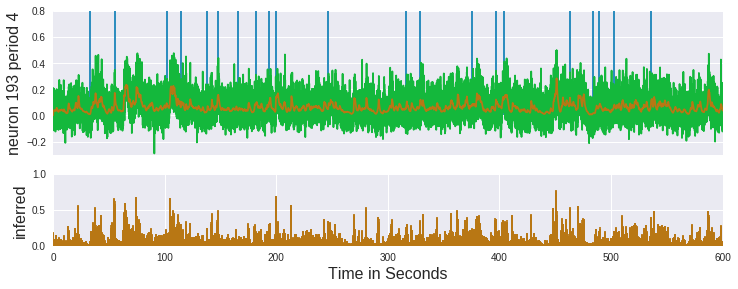

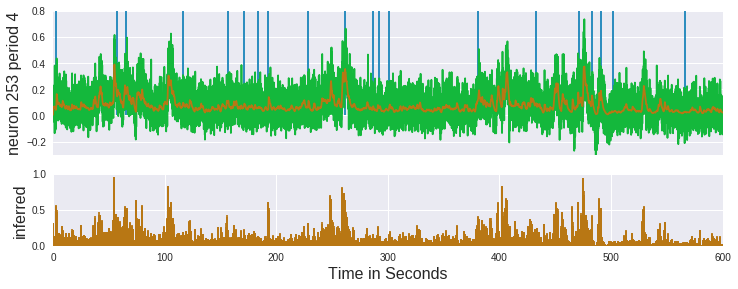

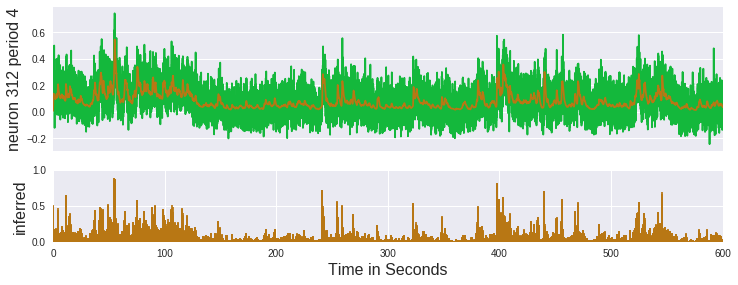

In [10]:
### Use perturbed neuron reconstructions and neuron synapses to find good spiking rate caused by perturbation as well
### as most probable connected neurons

### Neuron: 148
### Connected Neurons: 189, 193, 253, 312

neuron1 = 147
neuron2 = 188
neuron3 = 192
neuron4 = 252
neuron5 = 311

neuron_list = [neuron1, neuron2, neuron3, neuron4, neuron5]

for half in range(4):
    start_run = half*T
    
    ### Set correct dimensions for fluorescence and perturbations
    traces_half = traces_photo[start_run:start_run+T, :]
    stim_half = stim[start_run:start_run+T, :]
    
    traces_ups_half = upsampling_average(upsample_factor, traces_half, T, Nc)
    perturbations_ups_half = upsampling_zero(upsample_factor, stim_half, T, Ns)
    
    ### Recover the inferred spikes
    inferred_spikes = session.run(spikes.Q.mean(), feed_dict = {ca_raw_upsampled: traces_ups_half, raw_inp_upsampled: perturbations_ups_half})

    ### Recover the reconstructed fluorescent traces
    reconstruction = session.run(calcium.Erecon, feed_dict = {ca_raw_upsampled: traces_ups_half, raw_inp_upsampled: perturbations_ups_half})

    for neuron in neuron_list:
        if neuron < 254:
            ### Plot
            plot_inf_soma_stim_recon('neuron ' + str(neuron+1) + ' period '+ str(half+1), inferred_spikes[:, neuron], 0, traces_ups_half[:, neuron], reconstruction[:, neuron], perturbations_ups_half[:,neuron], 1/60, upsample_factor, cp)
        else:
            plot_inf_soma_gt_recon('neuron ' + str(neuron+1) + ' period '+ str(half+1), inferred_spikes[:, neuron], 0, traces_ups_half[:, neuron], reconstruction[:, neuron], 1/60, upsample_factor, cp)

## Calculate Spike Triggered Averages for the Same Synapses

In [25]:
### Function to calculate and plot spike-triggered averages for entire trial
def spike_trigger_avg_whole(input_neuron, upsample, cp, bin_period, fs=14,
                      fig=None, grid=None):
    
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax3 = fig.add_subplot(gs[1])
    
    length = int(2*(1/bin_period))
    
    for half in range(4):
        start_run = half*T
        
        ### Set correct dimensions for fluorescence and perturbations
        traces_half = traces_photo[start_run:start_run+T, :]
        stim_half = stim[start_run:start_run+T, :]
        
        traces_ups_half = upsampling_average(upsample_factor, traces_half, T, Nc)
        perturbations_ups_half = upsampling_zero(upsample_factor, stim_half, T, Ns)
        
        ### Recover the inferred spikes
        inferred_spikes = session.run(spikes.Q.mean(), feed_dict = {ca_raw_upsampled: traces_ups_half, raw_inp_upsampled: perturbations_ups_half})
        
        ### Recover the reconstructed fluorescent traces
        reconstruction = session.run(calcium.Erecon, feed_dict = {ca_raw_upsampled: traces_ups_half, raw_inp_upsampled: perturbations_ups_half})
        
        curr_traces = traces_ups_half[:, input_neuron]
        curr_recon = reconstruction[:, input_neuron]
        curr_spikes = inferred_spikes[:, input_neuron]
        curr_stim = perturbations_ups_half[:, 147]
        #curr_stim = stim
        
        average_trace = np.zeros(int(length*2))
        average_recon = np.zeros(int(length*2))
        average_spikes = np.zeros(int(length*2))
        counter = 0
        num_perts = 0
        
        x = np.arange(len(average_trace))
        t = x * bin_period
        
        for i in curr_stim:
            if i != 0:
                average_trace += curr_traces[counter-length:counter+length:,]
                average_recon += curr_recon[counter-length:counter+length:,]
                average_spikes += curr_spikes[counter-length:counter+length:,]
                num_perts += 1
            counter += 1
    
    average_trace = average_trace/num_perts
    average_recon = average_recon/num_perts
    average_spikes = average_spikes/num_perts
    
    ax1.set_ylabel("Activity", fontsize=fs + 2, y=0.5)
    ax1.plot(t, average_trace, label="Trace", color=cp[4])
    #ax1.plot(t, average_recon, label="Recon", color=cp[1])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax1.set_xlim([t.min(), t.max()])
    #ax1.set_ylim([0, 0.13])
    #ax1.set_xlabel('Time in Seconds', fontsize=fs + 2)
    
    ax3.plot(t, average_spikes, label="Recon", color=cp[1])
    ax3.set_xlim([t.min(), t.max()])
    #ax3.set_ylim([0, 1])
    ax3.set_ylabel('Inferred', fontsize=fs + 2, y=0.5)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlabel('Time in Seconds', fontsize=fs + 2)

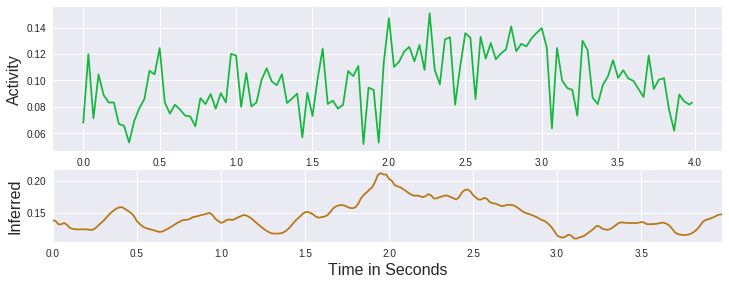

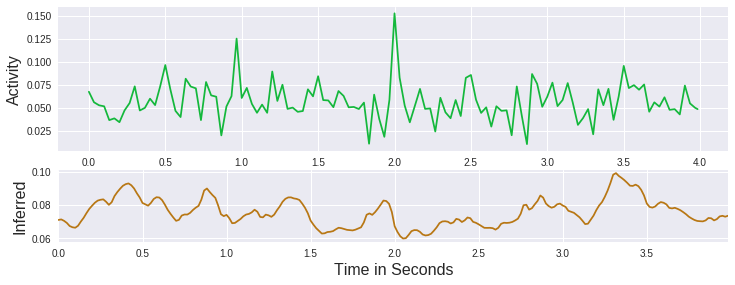

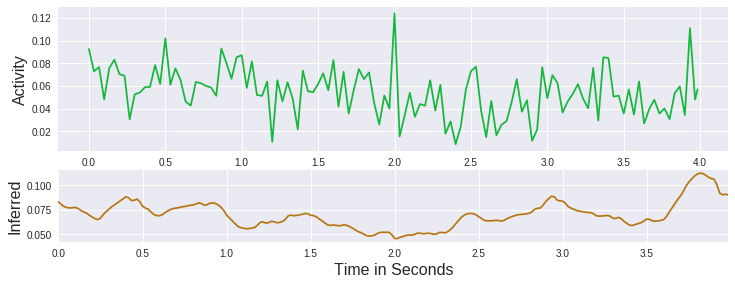

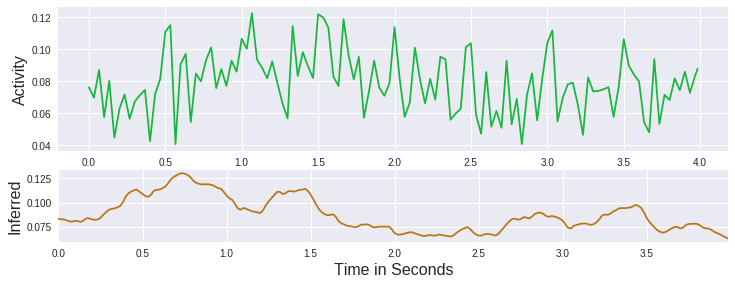

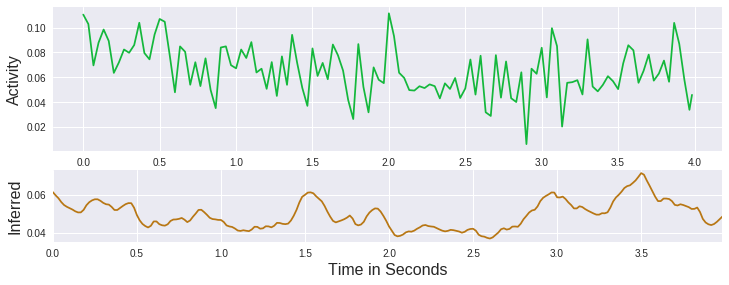

In [26]:
neuron1 = 147
neuron2 = 188
neuron3 = 192
neuron4 = 252
neuron5 = 311

connected_neurons = [neuron1, neuron2, neuron3, neuron4, neuron5]

for neuron in connected_neurons:
    spike_trigger_avg_whole(neuron, 2, cp, 1/60)